**3.1**

In [ ]:
%matplotlib inline
import math
import time
import numpy as np
import torch

ModuleNotFoundError: No module named 'd2l'

In [ ]:
#libraries are much better optimized relative to python for loops LMFAO
n = 10000
a = torch.arange(n)
b = torch.arange(n)

In [ ]:
c = torch.zeros(n)
t = time.time()
for i in range(len(a)):
    c[i] = a[i] + b[i]

print(f'Execution time: {time.time() - t:.5f} sec')



Execution time: 0.17031 sec


In [ ]:
t = time.time()
d = a + b
print(f'Execution time: {time.time() - t:.5f} sec')


Execution time: 0.00102 sec


**3.2 Review of D2L Modules. Review once we have some more theoretical understanding**

In [ ]:
%%capture
!pip install --upgrade d2l==1.0.0a0
import time
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l


In [ ]:
def add_to_class(Class):  #save
    """Register functions as methods in created class."""
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

In [ ]:
class A:
  def __init__(self):
    self.b = 1
a = A()

In [ ]:
@add_to_class(A)
def do(self):
  print(f'Class Attribute b is: {self.b}')
a.do()

Class Attribute b is: 1


In [ ]:
class B(d2l.HyperParameters):
    def __init__(self, a, b, c):
        self.save_hyperparameters(ignore=['c'])
        print('self.a =', self.a, 'self.b =', self.b)
        print('There is no self.c =', not hasattr(self, 'c'))

b = B(a=1, b=2, c=3)

self.a = 1 self.b = 2
There is no self.c = True


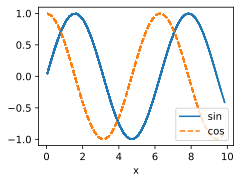

In [ ]:
board = d2l.ProgressBoard('x')
for x in np.arange(0, 10, 0.1):
    board.draw(x, np.sin(x), 'sin', every_n=2)
    board.draw(x, np.cos(x), 'cos', every_n=2)

**3.3 Synthetic Regression Data**

In [ ]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [ ]:
class SyntheticRegressionData(d2l.DataModule):
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000,
                 batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, len(w))
        noise = torch.randn(n, 1) * noise
        self.y = torch.matmul(self.X, w.reshape((-1, 1))) + b + noise

In [ ]:
data = SyntheticRegressionData(w = torch.tensor([2, -3.4]), b = 4.2)
print(f"Features: {data.X[0]}, Label: {data.y[0]}")

Features: tensor([2.3469, 1.8311]), Label: tensor([2.6693])


In [ ]:
@d2l.add_to_class(SyntheticRegressionData)
def get_dataloader(self, train):
    if train:
        indices = list(range(0, self.num_train))
        # The examples are read in random order
        random.shuffle(indices)
    else:
        indices = list(range(self.num_train, self.num_train+self.num_val))
    for i in range(0, len(indices), self.batch_size):
        batch_indices = torch.tensor(indices[i: i+self.batch_size])
        yield self.X[batch_indices], self.y[batch_indices]

In [ ]:
#yield creates an iterator with "blocks". can iterate through with for loop
for X, y in (data.train_dataloader()):
  print('X shape:', X.shape, '\ny shape:', y.shape)

In [ ]:
@d2l.add_to_class(d2l.DataModule)
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    dataset = torch.utils.data.TensorDataset(*tensors)
    return torch.utils.data.DataLoader(dataset, self.batch_size,
                                       shuffle=train)

@d2l.add_to_class(SyntheticRegressionData)
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)

**3.4 Lin Reg Implementation from Scratch**

In [ ]:
%matplotlib inline
import torch
from d2l import torch as d2l

In [ ]:
class LinearRegressionScratch(d2l.Module):
  def __init__(self, num_inputs, lr, sigma = 0.01):
    super().__init__()
    self.save_hyperparameters()
    self.w = torch.normal(0, sigma, (num_inputs,1), requires_grad = True)
    self.b = torch.zeros(1, requires_grad = True)

In [ ]:
@d2l.add_to_class(LinearRegressionScratch)
def forward(self, X):
  return torch.matmul(X, self.w) + self.b

In [ ]:
@d2l.add_to_class(LinearRegressionScratch)
def loss(self, y_hat, y):
  loss = (y_hat - y)**2 / 2
  return loss.mean()

In [ ]:
class SGD(d2l.HyperParameters):
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

In [ ]:
class SGD(d2l.HyperParameters):
  def __init__(self, params, lr):
    self.save_hyperparameters()

# takes a step in the direction of the gradient. assuming that no sign adjustments are made to the grad, so positive derivative
  def step(self):
    for param in self.params:
      param -= self.lr * param.grad

# can't call .zero_() on none i'm assuming? or maybe just saves a little bit of computation
  def zero_grad(self):
    for param in self.params:
      param.grad.zero_()

@d2l.add_to_class(LinearRegressionScratch)
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

In [ ]:
@d2l.add_to_class(d2l.Trainer)
def prepare_batch(self, batch):
    return batch

@d2l.add_to_class(d2l.Trainer)
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

what the fuck is the trainer class.....

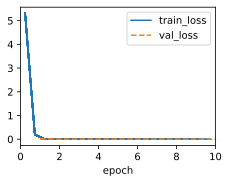

In [ ]:
model = LinearRegressionScratch(2, lr=0.1)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

In [ ]:
with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'error in estimating b: {data.b - model.b}')

error in estimating w: tensor([ 0.1087, -0.1623])
error in estimating b: tensor([0.1966])


In [ ]:
print(model.w.shape)
print(data.w.shape)

torch.Size([2, 1])
torch.Size([2])


**3.5 Concise Implementation of Linear Regression**

In [ ]:
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

ModuleNotFoundError: No module named 'd2l'

In [ ]:
class LinearRegression(d2l.Module):
    """The linear regression model implemented with high-level APIs."""
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1)
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)

In [ ]:
@d2l.add_to_class(LinearRegression)
def forward(self, X):
    return self.net(X)

In [ ]:
@d2l.add_to_class(LinearRegression)
def loss(self, y_hat, y):
    fn = nn.MSELoss()
    return fn(y_hat, y)

In [ ]:
@d2l.add_to_class(LinearRegression)
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), self.lr)

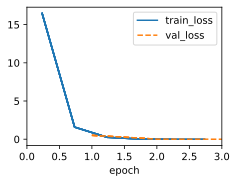

In [ ]:
model = LinearRegression(lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

**3.7 Weight Decay**

In [ ]:
%%capture
!pip install --upgrade d2l==1.0.0a0
import time
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
class Data(d2l.DataModule):
  def __init__(self, num_train, num_vals, num_inputs, batch_size):
    self.save_hyperparameters()
    n = num_train + num_vals
    self.X = torch.randn(n, num_inputs)
    noise = torch.rand(n, 1) * 0.01
    w,b = torch.randn(num_inputs,1) * 0.01, 0.05
    self.y = torch.matmul(self.X,w) + b + noise

  def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader([self.X, self.y], train, i)


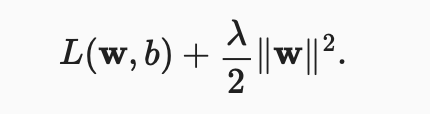

In [ ]:
def l2_penalty(w):
  return (w ** 2).sum() / 2

In [ ]:
class WeightDecayScratch(d2l.LinearRegressionScratch):
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)
        self.save_hyperparameters()

    def loss(self, y_hat, y):
        return (super().loss(y_hat, y) +
                self.lambd * l2_penalty(self.w))

In [ ]:
class WeightDecayScratch(d2l.LinearRegressionScratch):
  def __init__(self, num_inputs, lambd, lr, sigma = 0.01):
    super().__init__(num_inputs, lr, sigma)
    self.save_hyperparameters
    self.lambd = lambd
  def loss(self, y_hat, y):
    return(super().loss(y_hat, y) + self.lambd * l2_penalty(self.w))

In [ ]:
data = Data(num_train=20, num_vals=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)

def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    model.board.yscale='log'
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))

In [ ]:
data = Data(num_train = 20, num_vals = 100, num_inputs = 200, batch_size = 5)
trainer = d2l.Trainer(max_epochs = 10)

def train_scratch(lambd):
  model = WeightDecayScratch(num_inputs= 200, lambd=lambd, lr = 0.01)
  model.board.yscale = 'log'
  trainer.fit(model, data)
  print('L2 norm of w:', float(l2_penalty(model.w)))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'clip_gradients', 'epoch', 'fit', 'fit_epoch', 'gpus', 'gradient_clip_val', 'hparams', 'max_epochs', 'model', 'num_gpus', 'num_train_batches', 'num_val_batches', 'optim', 'prepare_batch', 'prepare_data', 'prepare_model', 'save_hyperparameters', 'train_batch_idx', 'train_dataloader', 'val_batch_idx', 'val_dataloader']


L2 norm of w: 0.00037787260953336954


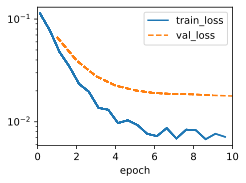

In [ ]:
train_scratch(10)

In [ ]:
class WeightDecay(d2l.LinearRegression):
  def __init__(self, wd, lr):
    super().__init__(lr)
    self.save_hyperparameters()
    self.wd = wd

  def configure_optimizers(self):
    return torch.optim.SGD([
        {'params': self.net.weight, 'weight_decay': self.wd},
        {'params': self.net.bias}])

L2 norm of w: 0.11127690970897675


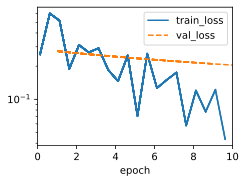

In [ ]:
model = WeightDecay(wd = 3, lr = 0.01)
model.board.yscale = 'log'
trainer.fit(model, data)

print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))

In [ ]:
dir(trainer)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'clip_gradients',
 'epoch',
 'fit',
 'fit_epoch',
 'gpus',
 'gradient_clip_val',
 'hparams',
 'max_epochs',
 'model',
 'num_gpus',
 'num_train_batches',
 'num_val_batches',
 'optim',
 'prepare_batch',
 'prepare_data',
 'prepare_model',
 'save_hyperparameters',
 'train_batch_idx',
 'train_dataloader',
 'val_batch_idx',
 'val_dataloader']

In [ ]:
print(model.get_w_b()[0])
print(model.get_w_b()[1])

tensor([[-0.0019, -0.0560,  0.0496,  0.0527, -0.0034,  0.0064, -0.0413,  0.0530,
         -0.0377,  0.0171, -0.0578,  0.0173, -0.0078, -0.0238, -0.0110, -0.0277,
         -0.0407,  0.0190, -0.0419, -0.0247, -0.0297, -0.0117, -0.0392, -0.0375,
         -0.0430, -0.0679,  0.0276,  0.0292, -0.0042,  0.0441,  0.0153,  0.0588,
          0.0246,  0.0143, -0.0477,  0.0048, -0.0031,  0.0193,  0.0396, -0.0255,
         -0.0425, -0.0264,  0.0358,  0.0575,  0.0102, -0.0152, -0.0319,  0.0512,
         -0.0265, -0.0027, -0.0105,  0.0124,  0.0242,  0.0369,  0.0467, -0.0545,
         -0.0236,  0.0513, -0.0094, -0.0247,  0.0028,  0.0447, -0.0321, -0.0379,
          0.0388,  0.0546, -0.0409,  0.0336,  0.0559, -0.0266, -0.0098, -0.0093,
          0.0109, -0.0370,  0.0139, -0.0251, -0.0476,  0.0084,  0.0117, -0.0319,
          0.0312, -0.0067, -0.0323, -0.0023,  0.0553,  0.0187,  0.0644, -0.0463,
         -0.0581, -0.0481,  0.0206,  0.0176,  0.0375, -0.0353,  0.0741, -0.0537,
          0.0192,  0.0452,  

In [ ]:
data.X.size()

torch.Size([120, 200])

In [ ]:
# Calculate final training loss
total_train_loss = 0
num_train_batches = 0
model.eval() # Set the model to evaluation mode
with torch.no_grad(): # Disable gradient calculations
    for X, y in data.train_dataloader():
        y_hat = model(X)
        loss = model.loss(y_hat, y)
        total_train_loss += loss.item() * X.size(0) # Accumulate loss, weighted by batch size
        num_train_batches += 1

avg_train_loss = total_train_loss / len(data.X[:data.num_train]) # Calculate average loss
print(f'Final Training Loss: {avg_train_loss:.6f}')

# Calculate final validation loss
total_val_loss = 0
num_val_batches = 0
model.eval() # Ensure model is in evaluation mode
with torch.no_grad(): # Disable gradient calculations
    for X, y in data.val_dataloader():
        y_hat = model(X)
        loss = model.loss(y_hat, y)
        total_val_loss += loss.item() * X.size(0) # Accumulate loss, weighted by batch size
        num_val_batches += 1

avg_val_loss = total_val_loss / len(data.X[data.num_train:]) # Calculate average loss
print(f'Final Validation Loss: {avg_val_loss:.6f}')

Final Training Loss: 0.070484
Final Validation Loss: 0.204509


In [ ]:
##Coding Practice: Assume that the model has already bene fitted according to your trainer. Compare your compare training and validation losses:

#want to calculate the total val loss

tot_train_loss = 0
model.eval()
with torch.no_grad():
  for X,y in data.train_dataloader():
    y_hat = model(X)
    loss = model.loss(y_hat, y)
    tot_train_loss += loss * data.batch_size

average_train_loss = (tot_train_loss / data.num_train).item()

tot_val_loss = 0
model.eval()
with torch.no_grad():
  for X,y in data.val_dataloader():
    y_hat = model(X)
    loss = model.loss(y_hat, y)
    tot_val_loss += loss * data.batch_size

average_val_loss = (tot_val_loss / data.num_vals).item()

print(f'Average Train Loss: {average_train_loss:.5f}\n Average Val Loss: {average_val_loss:.5f}')




Average Train Loss: 0.07048
 Average Val Loss: 0.20451


In [ ]:
dir(model)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_compiled_call_impl',
 '_forward_hooks',
 '_forward_hooks_always_called',
 '_forward_hooks_with_kwargs',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_se